# Background

In this notebook we create a model to predict if a user fails to pay back theit creid card balance. The data can be found here: (https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset)


The features are:


LIMIT_BAL: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.

SEX: (1 = male; 2 = female).

EDUCATION: (1 = graduate school; 2 = university; 3 = high school; 0, 4, 5, 6 = others).

MARRIAGE: Marital status (1 = married; 2 = single; 3 = divorce; 0=others).

AGE: Age (year).

PAY_1 to PAY_6: History of past payment, from April(PAY_6) to September(PAY_1) 2005 and is as follows: (-2: No consumption; -1: Paid in full; 0: The use of revolving credit; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months and above.)

BILL_AMT1 to BILL_AMT6: Amount of bill statement (dollar) from April (BILL_AMT6) to Setember(BILL_AMT1) 2005.

PAY_AMT1 to PAY_AMT6: Amount of previous payment (dollar) from April (PAY_AMT6) to Setember(PAY_AMT1) 2005.

dpnm: (0: Fully Paid, 1: default")

# Executive Summary

In this notebook, we created a model to predict if a credit card holder pays his/her balance back or fail to do so.

Approach
22% of payments were default and we used SMOTE to address the issue

Gradient Boosting gives the best result and reached 94% area under the curve.

There is no significant difference between men and women in paying back their balance.

People with higher credit limits perform better in paying back their balance

PAY_1, LIMIT_BAL and AGE are the most effective parameters.

If a credit holder fails to pay their last payment, chances are that they also will fail to pay their next one

The higher credit limit a credit holder has, the better they perfom










In [498]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')


from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn import tree, metrics
from IPython.display import Image  
import pydotplus

from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier, cv, plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve, accuracy_score, confusion_matrix, balanced_accuracy_score, plot_roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline


from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE


from sklearn.compose import ColumnTransformer

import pickle



from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from sklearn.inspection import permutation_importance


In [499]:
DIR = 'C:\\Users\\somfl\\Documents\\GitHub\\CreditDefaultPrediction\\DataFiles'
filename = os.path.join(DIR, 'default of credit card clients.csv') 


In [500]:
df = pd.read_csv(filename)

In [501]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,dpnm
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [502]:
df.shape

(30000, 25)

In [503]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         30000 non-null  int64
 1   LIMIT_BAL  30000 non-null  int64
 2   SEX        30000 non-null  int64
 3   EDUCATION  30000 non-null  int64
 4   MARRIAGE   30000 non-null  int64
 5   AGE        30000 non-null  int64
 6   PAY_1      30000 non-null  int64
 7   PAY_2      30000 non-null  int64
 8   PAY_3      30000 non-null  int64
 9   PAY_4      30000 non-null  int64
 10  PAY_5      30000 non-null  int64
 11  PAY_6      30000 non-null  int64
 12  BILL_AMT1  30000 non-null  int64
 13  BILL_AMT2  30000 non-null  int64
 14  BILL_AMT3  30000 non-null  int64
 15  BILL_AMT4  30000 non-null  int64
 16  BILL_AMT5  30000 non-null  int64
 17  BILL_AMT6  30000 non-null  int64
 18  PAY_AMT1   30000 non-null  int64
 19  PAY_AMT2   30000 non-null  int64
 20  PAY_AMT3   30000 non-null  int64
 21  PAY_AMT4   3

In [504]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,dpnm
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


## Check missing data

In [505]:
df.isnull().sum()

ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_1        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
dpnm         0
dtype: int64

## Check Duplicate

In [506]:
df.drop('ID', axis=1, inplace=True)

In [507]:
df.duplicated().sum()

35

In [508]:
## Drop duplicates
df.drop_duplicates(inplace=True)

## Correlation 

The following heatmap shows the correlation between all the features in the dataset. Of notable correlations (all positive) are "BILL_AMT" features with one another, then "PAY" features with eachother, respectively. It means that, in general, whether bill payments will be done on time or will have delays are somewhat correlated, but the bill statements are very correlated with eachother. This can be an issue when using models such as Logistic Linear Regression, but not so much for Decision Tree or Random Forest classifiers.

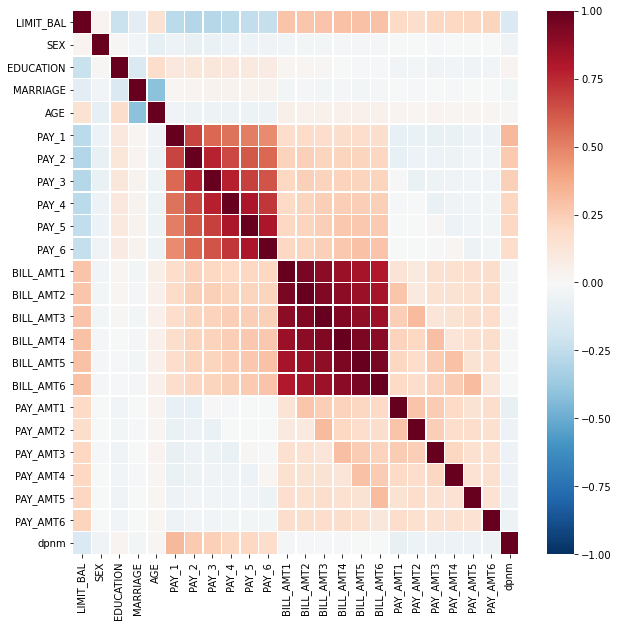

In [71]:
plt.figure(figsize = (10,10))
sns.heatmap(df.select_dtypes(np.number).corr() ,xticklabels=df.select_dtypes(np.number).corr().columns, yticklabels=df.select_dtypes(np.number).corr().columns, annot=False, cmap="RdBu_r",linewidths=.6,vmin=-1, vmax=1);


## Target prediction: dpnm

As Shown below in the graph, the data is imbalanced and we need to address it when modeling.

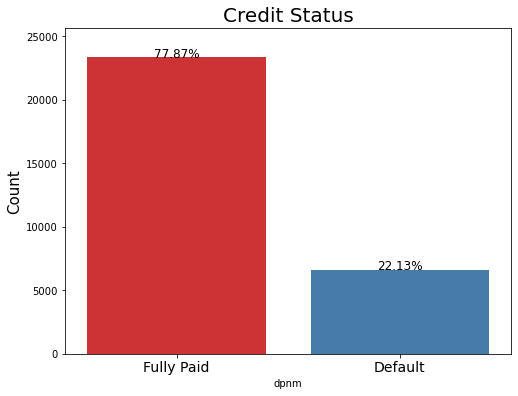

In [509]:
plt.figure(figsize = (8,6))

ax = sns.countplot(x="dpnm", data=df, palette="Set1")
# ax.set_xticklabels(ax.get_xticklabels(),rotation=0, fontsize=14)
ax.set_xticklabels(['Fully Paid', 'Default'],rotation=0, fontsize=14)

total = len(df)

ax.set_ylabel("Count", fontsize=15)
ax.set_title("Credit Status", fontsize=20)
sizes=[]
for p in ax.patches:
    height = p.get_height()
    sizes.append(height)
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 
ax.set_ylim(0, max(sizes) * 1.10)

plt.show()

## Sex, Education, Marital Status

Gender (1 = male; 2 = female).

Education (1 = graduate school; 2 = university; 3 = high school; 0, 4, 5, 6 = others).

Marital status (1 = married; 2 = single; 3 = divorce; 0=others).

In [510]:
df['SEX'].replace([1, 2], ['Male', 'Female'], inplace=True)
df['EDUCATION'].replace([1, 2, 3, 0, 4, 5, 6], ['Graduate School', 'University', 'High School', 'Others', 'Others', 'Others', 'Others'], inplace=True)
df['MARRIAGE'].replace([1, 2, 3, 0], ['Married', 'Single', 'Divorced', 'Others'], inplace=True)

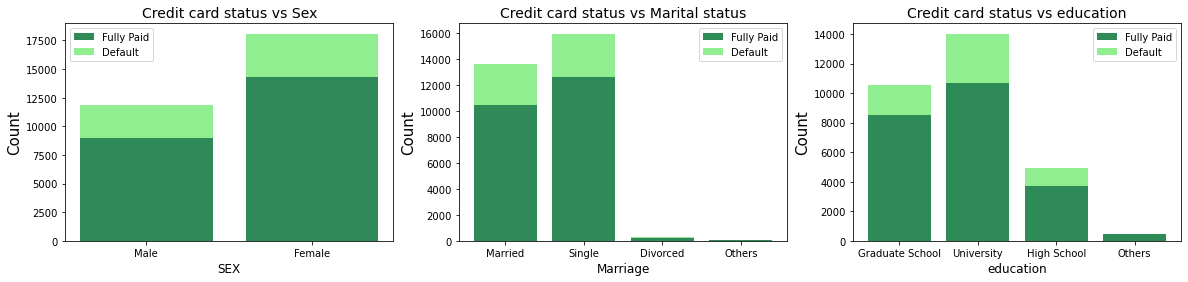

In [511]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows = 1, ncols = 3, figsize=(20,4))

s1 = pd.DataFrame({'Fully Paid': df.loc[df['dpnm']==0, 'SEX'].value_counts(), 'Default': df.loc[df['dpnm']==1, 'SEX'].value_counts()}, index=None)
s2 = pd.DataFrame({'Fully Paid': df.loc[df['dpnm']==0, 'MARRIAGE'].value_counts(), 'Default': df.loc[df['dpnm']==1, 'MARRIAGE'].value_counts()}, index=None)
s3 = pd.DataFrame({'Fully Paid': df.loc[df['dpnm']==0, 'EDUCATION'].value_counts(), 'Default': df.loc[df['dpnm']==1, 'EDUCATION'].value_counts()}, index=None)

s1 = s1.reindex(['Male', 'Female'])
s2 = s2.reindex(['Married', 'Single', 'Divorced', 'Others'])
s3 = s3.reindex(['Graduate School', 'University', 'High School', 'Others'])

ax1.bar(s1.index, s1['Fully Paid'], color='seagreen')
ax1.bar(s1.index, s1['Default'], bottom=s1['Fully Paid'], color='lightgreen')
ax1.set_xticklabels(s1.index, rotation=0)
ax1.legend(['Fully Paid', 'Default'])
ax1.set_xlabel('SEX', fontsize=12)
ax1.set_ylabel('Count', fontsize=15)
ax1.set_title("Credit card status vs Sex", fontsize=14)


ax2.bar(s2.index, s2['Fully Paid'], color='seagreen')
ax2.bar(s2.index, s2['Default'], bottom=s2['Fully Paid'], color='lightgreen')
ax2.set_xticklabels(s2.index, rotation=0)
ax2.legend(['Fully Paid', 'Default'])
ax2.set_xlabel('Marriage', fontsize=12)
ax2.set_ylabel('Count', fontsize=15)
ax2.set_title("Credit card status vs Marital status", fontsize=14)

ax3.bar(s3.index, s3['Fully Paid'], color='seagreen')
ax3.bar(s3.index, s3['Default'], bottom=s3['Fully Paid'], color='lightgreen')
ax3.set_xticklabels(s3.index, rotation=0)
ax3.legend(['Fully Paid', 'Default'])
ax3.set_xlabel('education', fontsize=12)
ax3.set_ylabel('Count', fontsize=15)
ax3.set_title("Credit card status vs education", fontsize=14)


plt.show()

## AGE

No handles with labels found to put in legend.


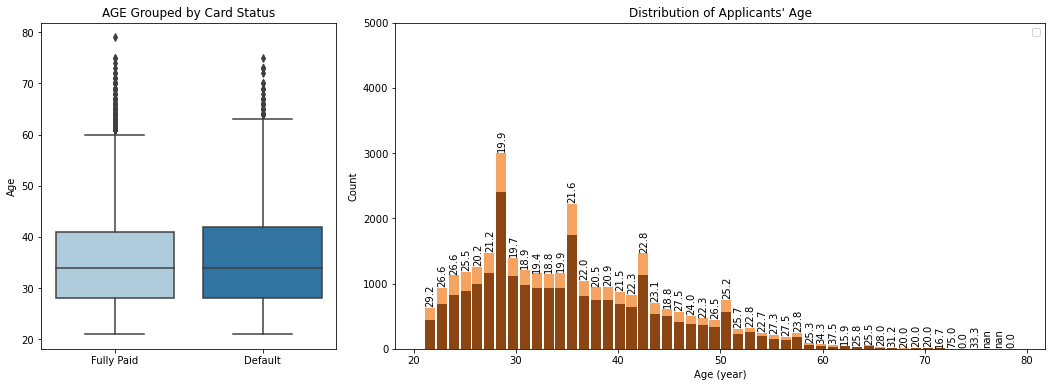

In [512]:
fig = plt.figure(figsize = (18,6))
ax1 = plt.subplot2grid((1,3),(0,0))
ax2 = plt.subplot2grid((1,3),(0,1), colspan=2)

sns.boxplot(y="AGE", x="dpnm", data=df, ax = ax1)
ax1.set_xlabel('')
ax1.set_xticks([0,1])
ax1.set_xticklabels(['Fully Paid','Default'], ha='center')
ax1.set_title('AGE Grouped by Card Status')
ax1.set_ylabel('Age')

s1 = pd.DataFrame({'Fully Paid': df.loc[df['dpnm']==0, 'AGE'], 'Default': df.loc[df['dpnm']==1, 'AGE']}, index=None)
ax2.hist(s1, stacked=True, bins=50, rwidth=0.85, color=["saddlebrown", "sandybrown"]);
ax2.set_title("Distribution of Applicants' Age")
ax2.set_xlabel('Age (year)')
ax2.set_ylabel('Count')
ax2.set_ylim(0,5000)
ax2.legend()
    
p = ax2.patches
for i in range(0,50,1):
    x1, y1 = p[i].get_xy()
    x2, y2 = p[i+1].get_xy()
    x = x1 + .05
    Y1 = p[i].get_height()
    Y2 = p[i+50].get_height()
    y = Y2 + Y1 + 50
    a = Y2/(Y2 + Y1)
    ax2.text(x, y, round(a*100,1), rotation=90)

# Credit card limit

No handles with labels found to put in legend.


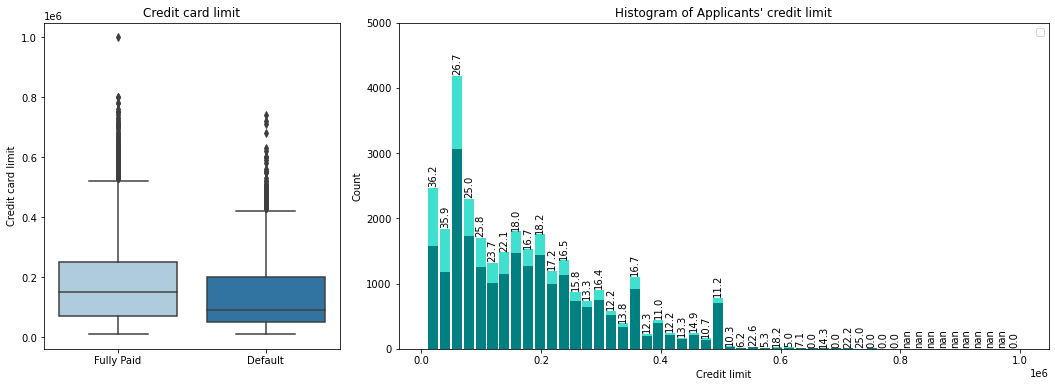

In [513]:
fig = plt.figure(figsize = (18,6))
ax1 = plt.subplot2grid((1,3),(0,0))
ax2 = plt.subplot2grid((1,3),(0,1), colspan=2)

sns.boxplot(y='LIMIT_BAL', x='dpnm', data=df, ax = ax1)
ax1.set_xlabel('')
ax1.set_xticks([0,1])
ax1.set_xticklabels(['Fully Paid','Default'], ha='center')
ax1.set_title('Credit card limit')
ax1.set_ylabel('Credit card limit')

s1 = pd.DataFrame({'Fully Paid': df.loc[df['dpnm']==0, 'LIMIT_BAL'], 'Default': df.loc[df['dpnm']==1, 'LIMIT_BAL']}, index=None)
ax2.hist(s1, stacked=True, bins=50, rwidth=0.85, color=['teal', "turquoise"]);
ax2.set_title("Histogram of Applicants' credit limit")
ax2.set_xlabel('Credit limit')
ax2.set_ylabel('Count')
ax2.set_ylim(0,5000)
ax2.legend()
    
p = ax2.patches
for i in range(0,50,1):
    x1, y1 = p[i].get_xy()
    x2, y2 = p[i+1].get_xy()
    x = x1 + .05
    Y1 = p[i].get_height()
    Y2 = p[i+50].get_height()
    y = Y2 + Y1 + 50
    a = Y2/(Y2 + Y1)
    ax2.text(x, y, round(a*100,1), rotation=90)

## Payment Status

In [515]:
df['PAY_1'].replace([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['No consumption', 'Paid in full', 'Use of revolving credit', 
                                                             'Delay for one month','Delay for two months',
                                                             'Delay for three months', 'Delay for four months', 
                                                             'Delay for five months', 'Delay for six months',
                                                             'Delay for seven months', 'Delay for eight months', 
                                                             'Delay for nine months and above'], inplace=True)
df['PAY_2'].replace([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['No consumption', 'Paid in full', 'Use of revolving credit', 
                                                             'Delay for one month','Delay for two months',
                                                             'Delay for three months', 'Delay for four months', 
                                                             'Delay for five months', 'Delay for six months',
                                                             'Delay for seven months', 'Delay for eight months', 
                                                             'Delay for nine months and above'], inplace=True)
df['PAY_3'].replace([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['No consumption', 'Paid in full', 'Use of revolving credit', 
                                                             'Delay for one month','Delay for two months',
                                                             'Delay for three months', 'Delay for four months', 
                                                             'Delay for five months', 'Delay for six months',
                                                             'Delay for seven months', 'Delay for eight months', 
                                                             'Delay for nine months and above'], inplace=True)
df['PAY_4'].replace([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['No consumption', 'Paid in full', 'Use of revolving credit', 
                                                             'Delay for one month','Delay for two months',
                                                             'Delay for three months', 'Delay for four months', 
                                                             'Delay for five months', 'Delay for six months',
                                                             'Delay for seven months', 'Delay for eight months', 
                                                             'Delay for nine months and above'], inplace=True)
df['PAY_5'].replace([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['No consumption', 'Paid in full', 'Use of revolving credit', 
                                                             'Delay for one month','Delay for two months',
                                                             'Delay for three months', 'Delay for four months', 
                                                             'Delay for five months', 'Delay for six months',
                                                             'Delay for seven months', 'Delay for eight months', 
                                                             'Delay for nine months and above'], inplace=True)
df['PAY_6'].replace([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['No consumption', 'Paid in full', 'Use of revolving credit', 
                                                             'Delay for one month','Delay for two months',
                                                             'Delay for three months', 'Delay for four months', 
                                                             'Delay for five months', 'Delay for six months',
                                                             'Delay for seven months', 'Delay for eight months', 
                                                             'Delay for nine months and above'], inplace=True)


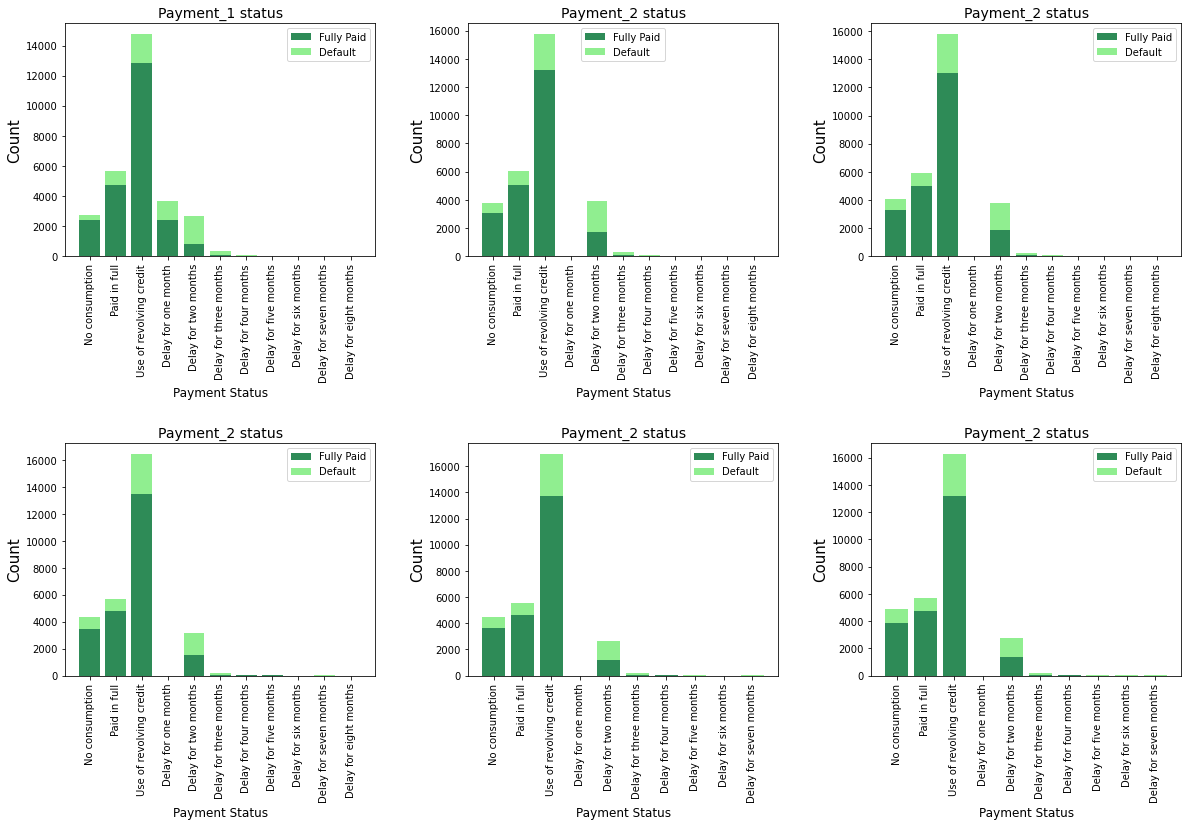

In [516]:
fig, [(ax1, ax2, ax3), (ax4, ax5, ax6)] = plt.subplots(nrows=2, ncols=3, figsize=(20,12))
s1 = pd.DataFrame({'Fully Paid': df.loc[df['dpnm']==0, 'PAY_1'].value_counts(), 'Default': df.loc[df['dpnm']==1, 'PAY_1'].value_counts()}, index=None)
s1 = s1.reindex(['No consumption', 'Paid in full', 'Use of revolving credit','Delay for one month','Delay for two months',
                 'Delay for three months', 'Delay for four months','Delay for five months', 'Delay for six months',
                 'Delay for seven months', 'Delay for eight months'])
s2 = pd.DataFrame({'Fully Paid': df.loc[df['dpnm']==0, 'PAY_2'].value_counts(), 'Default': df.loc[df['dpnm']==1, 'PAY_2'].value_counts()}, index=None)
s3 = pd.DataFrame({'Fully Paid': df.loc[df['dpnm']==0, 'PAY_3'].value_counts(), 'Default': df.loc[df['dpnm']==1, 'PAY_3'].value_counts()}, index=None)
s4 = pd.DataFrame({'Fully Paid': df.loc[df['dpnm']==0, 'PAY_4'].value_counts(), 'Default': df.loc[df['dpnm']==1, 'PAY_4'].value_counts()}, index=None)
s5 = pd.DataFrame({'Fully Paid': df.loc[df['dpnm']==0, 'PAY_5'].value_counts(), 'Default': df.loc[df['dpnm']==1, 'PAY_5'].value_counts()}, index=None)
s6 = pd.DataFrame({'Fully Paid': df.loc[df['dpnm']==0, 'PAY_6'].value_counts(), 'Default': df.loc[df['dpnm']==1, 'PAY_6'].value_counts()}, index=None)

s2 = s2.reindex(['No consumption', 'Paid in full', 'Use of revolving credit','Delay for one month','Delay for two months',
                 'Delay for three months', 'Delay for four months','Delay for five months', 'Delay for six months',
                 'Delay for seven months', 'Delay for eight months'])

s3 = s3.reindex(['No consumption', 'Paid in full', 'Use of revolving credit','Delay for one month','Delay for two months',
                 'Delay for three months', 'Delay for four months','Delay for five months', 'Delay for six months',
                 'Delay for seven months', 'Delay for eight months'])

s4 = s4.reindex(['No consumption', 'Paid in full', 'Use of revolving credit','Delay for one month','Delay for two months',
                 'Delay for three months', 'Delay for four months','Delay for five months', 'Delay for six months',
                 'Delay for seven months', 'Delay for eight months'])

s5 = s5.reindex(['No consumption', 'Paid in full', 'Use of revolving credit','Delay for one month','Delay for two months',
                 'Delay for three months', 'Delay for four months','Delay for five months', 'Delay for six months',
                 'Delay for seven months', 'Delay for eight months'])

s6 = s6.reindex(['No consumption', 'Paid in full', 'Use of revolving credit','Delay for one month','Delay for two months',
                 'Delay for three months', 'Delay for four months','Delay for five months', 'Delay for six months',
                 'Delay for seven months', 'Delay for eight months'])

ax1.bar(s1.index, s1['Fully Paid'], color='seagreen')
ax1.bar(s1.index, s1['Default'], bottom=s1['Fully Paid'], color='lightgreen')
ax1.set_xticklabels(s1.index, rotation=90)
ax1.legend(['Fully Paid', 'Default'])
ax1.set_xlabel('Payment Status', fontsize=12)
ax1.set_ylabel('Count', fontsize=15)
ax1.set_title("Payment_1 status", fontsize=14)

ax2.bar(s2.index, s2['Fully Paid'], color='seagreen')
ax2.bar(s2.index, s2['Default'], bottom=s2['Fully Paid'], color='lightgreen')
ax2.set_xticklabels(s1.index, rotation=90)
ax2.legend(['Fully Paid', 'Default'])
ax2.set_xlabel('Payment Status', fontsize=12)
ax2.set_ylabel('Count', fontsize=15)
ax2.set_title("Payment_2 status", fontsize=14)

ax3.bar(s3.index, s3['Fully Paid'], color='seagreen')
ax3.bar(s3.index, s3['Default'], bottom=s3['Fully Paid'], color='lightgreen')
ax3.set_xticklabels(s1.index, rotation=90)
ax3.legend(['Fully Paid', 'Default'])
ax3.set_xlabel('Payment Status', fontsize=12)
ax3.set_ylabel('Count', fontsize=15)
ax3.set_title("Payment_2 status", fontsize=14)

ax4.bar(s4.index, s4['Fully Paid'], color='seagreen')
ax4.bar(s4.index, s4['Default'], bottom=s4['Fully Paid'], color='lightgreen')
ax4.set_xticklabels(s1.index, rotation=90)
ax4.legend(['Fully Paid', 'Default'])
ax4.set_xlabel('Payment Status', fontsize=12)
ax4.set_ylabel('Count', fontsize=15)
ax4.set_title("Payment_2 status", fontsize=14)


ax5.bar(s5.index, s5['Fully Paid'], color='seagreen')
ax5.bar(s5.index, s5['Default'], bottom=s5['Fully Paid'], color='lightgreen')
ax5.set_xticklabels(s1.index, rotation=90)
ax5.legend(['Fully Paid', 'Default'])
ax5.set_xlabel('Payment Status', fontsize=12)
ax5.set_ylabel('Count', fontsize=15)
ax5.set_title("Payment_2 status", fontsize=14)

ax6.bar(s6.index, s6['Fully Paid'], color='seagreen')
ax6.bar(s6.index, s6['Default'], bottom=s6['Fully Paid'], color='lightgreen')
ax6.set_xticklabels(s6.index, rotation=90)
ax6.legend(['Fully Paid', 'Default'])
ax6.set_xlabel('Payment Status', fontsize=12)
ax6.set_ylabel('Count', fontsize=15)
ax6.set_title("Payment_2 status", fontsize=14)
plt.subplots_adjust(hspace=0.8, wspace=.3);
plt.show()

## Histogram of Bill Amount

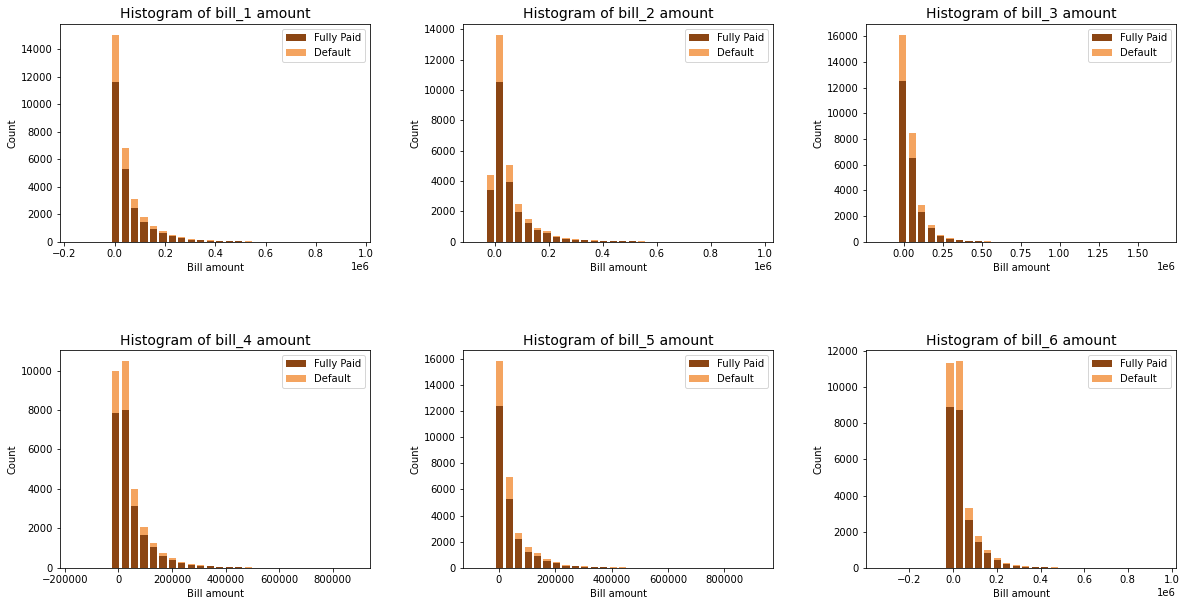

In [520]:
fig, [(ax1, ax2, ax3), (ax4, ax5, ax6)] = plt.subplots(nrows=2, ncols=3, figsize=(20,10))

s1 = pd.DataFrame({'Fully Paid': df.loc[df['dpnm']==0, 'BILL_AMT1'], 'Default': df.loc[df['dpnm']==1, 'BILL_AMT1']}, index=None)
s2 = pd.DataFrame({'Fully Paid': df.loc[df['dpnm']==0, 'BILL_AMT2'], 'Default': df.loc[df['dpnm']==1, 'BILL_AMT2']}, index=None)
s3 = pd.DataFrame({'Fully Paid': df.loc[df['dpnm']==0, 'BILL_AMT3'], 'Default': df.loc[df['dpnm']==1, 'BILL_AMT3']}, index=None)
s4 = pd.DataFrame({'Fully Paid': df.loc[df['dpnm']==0, 'BILL_AMT4'], 'Default': df.loc[df['dpnm']==1, 'BILL_AMT4']}, index=None)
s5 = pd.DataFrame({'Fully Paid': df.loc[df['dpnm']==0, 'BILL_AMT5'], 'Default': df.loc[df['dpnm']==1, 'BILL_AMT5']}, index=None)
s6 = pd.DataFrame({'Fully Paid': df.loc[df['dpnm']==0, 'BILL_AMT6'], 'Default': df.loc[df['dpnm']==1, 'BILL_AMT6']}, index=None)

ax1.hist(s1, stacked=True, bins=30, rwidth=0.75, color=["saddlebrown", "sandybrown"])
ax1.set_title("Histogram of bill_1 amount", fontsize=14)
ax1.set_xlabel('Bill amount')
ax1.set_ylabel('Count')
ax1.legend(['Fully Paid', 'Default'])

ax2.hist(s2, stacked=True, bins=30, rwidth=0.75, color=["saddlebrown", "sandybrown"])
ax2.set_title("Histogram of bill_2 amount", fontsize=14)
ax2.set_xlabel('Bill amount')
ax2.set_ylabel('Count')
ax2.legend(['Fully Paid', 'Default'])

ax3.hist(s3, stacked=True, bins=30, rwidth=0.75, color=["saddlebrown", "sandybrown"])
ax3.set_title("Histogram of bill_3 amount", fontsize=14)
ax3.set_xlabel('Bill amount')
ax3.set_ylabel('Count')
ax3.legend(['Fully Paid', 'Default'])

ax4.hist(s4, stacked=True, bins=30, rwidth=0.75, color=["saddlebrown", "sandybrown"])
ax4.set_title("Histogram of bill_4 amount", fontsize=14)
ax4.set_xlabel('Bill amount')
ax4.set_ylabel('Count')
ax4.legend(['Fully Paid', 'Default'])

ax5.hist(s5, stacked=True, bins=30, rwidth=0.75, color=["saddlebrown", "sandybrown"])
ax5.set_title("Histogram of bill_5 amount", fontsize=14)
ax5.set_xlabel('Bill amount')
ax5.set_ylabel('Count')
ax5.legend(['Fully Paid', 'Default'])

ax6.hist(s6, stacked=True, bins=30, rwidth=0.75, color=["saddlebrown", "sandybrown"])
ax6.set_title("Histogram of bill_6 amount", fontsize=14)
ax6.set_xlabel('Bill amount')
ax6.set_ylabel('Count')
ax6.legend(['Fully Paid', 'Default'])

plt.subplots_adjust(hspace=0.5, wspace=.3);
plt.show()


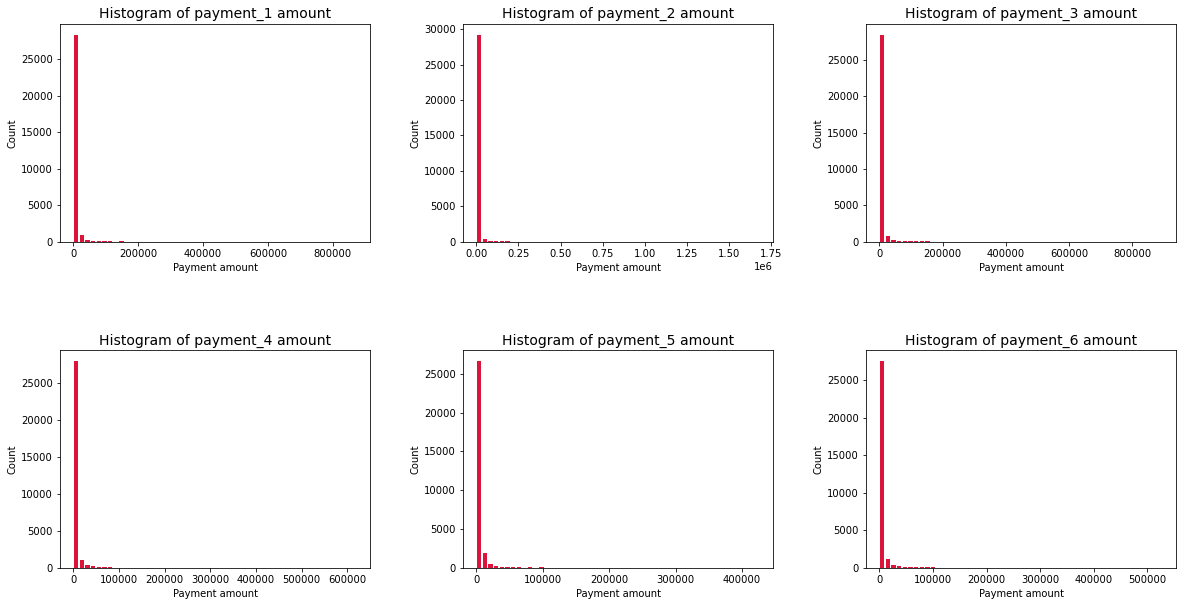

In [521]:
fig, [(ax1, ax2, ax3), (ax4, ax5, ax6)] = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
colors = ['darkblue', 'teal', 'coral', 'crimson', 'orchid', 'magenta']
ax1.hist(df['PAY_AMT1'], bins=50, rwidth=0.75, color=colors[3])
ax1.set_title("Histogram of payment_1 amount", fontsize=14)
ax1.set_xlabel('Payment amount')
ax1.set_ylabel('Count')
#ax1.set_ylim(0,5000)

ax2.hist(df['PAY_AMT2'], bins=50, rwidth=0.75, color=colors[3])
ax2.set_title("Histogram of payment_2 amount", fontsize=14)
ax2.set_xlabel('Payment amount')
ax2.set_ylabel('Count')
#ax1.set_ylim(0,5000)

ax3.hist(df['PAY_AMT3'], bins=50, rwidth=0.75, color=colors[3])
ax3.set_title("Histogram of payment_3 amount", fontsize=14)
ax3.set_xlabel('Payment amount')
ax3.set_ylabel('Count')
#ax1.set_ylim(0,5000)

ax4.hist(df['PAY_AMT4'], bins=50, rwidth=0.75, color=colors[3])
ax4.set_title("Histogram of payment_4 amount", fontsize=14)
ax4.set_xlabel('Payment amount')
ax4.set_ylabel('Count')
#ax1.set_ylim(0,5000)

ax5.hist(df['PAY_AMT5'], bins=50, rwidth=0.75, color=colors[3])
ax5.set_title("Histogram of payment_5 amount", fontsize=14)
ax5.set_xlabel('Payment amount')
ax5.set_ylabel('Count')
#ax1.set_ylim(0,5000)

ax6.hist(df['PAY_AMT6'], bins=50, rwidth=0.75, color=colors[3])
ax6.set_title("Histogram of payment_6 amount", fontsize=14)
ax6.set_xlabel('Payment amount')
ax6.set_ylabel('Count')
#ax1.set_ylim(0,5000)

plt.subplots_adjust(hspace=0.5, wspace=.3);
plt.show()


## Helper functions

In [523]:
def preprocess_model(classifier_name, grid_params, X_train, y_train, X_test, y_test):
    model = Pipeline(
    [
        ('preprocess', preprocessing),
        ('classifier', classifier_name)
    ]
    )
    grid_cv = GridSearchCV(model, param_grid=grid_params, scoring='balanced_accuracy', cv=5, n_jobs=-1)
    grid_cv.fit(X_train, y_train)
    
    y_pred = grid_cv.best_estimator_.predict(X_test)
    y_prob = grid_cv.best_estimator_.predict_proba(X_test)
    probs = y_prob[:,1]
    
    return probs, y_pred

def roc_auc_curve(y_test, probs):
    FalsePositiveRate, TruePositiveRate, threshold = metrics.roc_curve(y_test, probs, pos_label=1)
    roc_auc = metrics.auc(FalsePositiveRate, TruePositiveRate)
    return FalsePositiveRate, TruePositiveRate, threshold, roc_auc

def result_summary(probs, pred, fig_title):
    fig, ax = plt.subplots()
    colors = ['darkblue', 'brown', 'orchid', 'darkgreen']
    i = 0
    for item in probs:
        FalsePositiveRate, TruePositiveRate, threshold, roc_auc = roc_auc_curve(y_test, probs[item])
        #print(item, ':', roc_auc_score(y_test, pred[item]))
        label = 'AUC_'+ item +' = '    
        "{}{}".format(label, round(roc_auc,2))
        plt.plot(FalsePositiveRate, TruePositiveRate, color=colors[i], label =  "{}{}".format(label, round(roc_auc,2)))
        i += 1
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(fig_title)
    plt.show()
    
def total(clfs, fig_title):
    probs = {}
    pred = {}
    for clf in clfs:
        probs[clf['model_name']], pred[clf['model_name']] = preprocess_model(clf['Model'], clf['Parameters'], X_train, y_train, X_test, y_test)
    result_summary(probs, pred, fig_title)

# Undersampling technic
## Preprocessing

In [524]:
categorical_columns = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2','PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

numerical_columns = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
                     'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


yy = df['dpnm']
XX = df[numerical_columns + categorical_columns]

X_cols = XX.columns
y_col = ['status']

Xn = XX.to_numpy()
yn = yy.to_numpy()
random_state=42
RU = RandomUnderSampler()
X_res, y_res = RU.fit_resample(Xn,yn)

X = pd.DataFrame(X_res, columns=X_cols)
y = pd.DataFrame(y_res, columns=y_col)


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)


categorical_pipe = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown = "ignore"))])
numerical_pipe = Pipeline(steps=[('scaler', StandardScaler())])

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_pipe, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ]
)


In [525]:
X.shape

(13260, 23)

In [526]:
df.shape

(29965, 24)

In [527]:
clfs = [
    {'model_name': 'Logistic regression', 'Model': LogisticRegression(random_state=42), 'Parameters': {'classifier__C': [0.01, 0.1, 1, 10, 100], 'classifier__penalty' : ['l2']}},
    {'model_name': 'Random forest', 'Model': RandomForestClassifier(random_state=42), 'Parameters': {'classifier__max_depth': [7, 8, 9],'classifier__n_estimators': [60, 80], 'classifier__max_features': [7, 8]}},
    {'model_name': 'XGboost', 'Model': XGBClassifier(random_state=42), 'Parameters': {'classifier__learning_rate': [.2, 0.5], 'classifier__max_depth': [6, 9, 11], 'classifier__eval_metric':['mlogloss']}},
    {'model_name': 'Kneighbours', 'Model': KNeighborsClassifier(),'Parameters':{'classifier__n_neighbors' :[2,3], 'classifier__algorithm': ['auto', 'ball_tree']}}
]


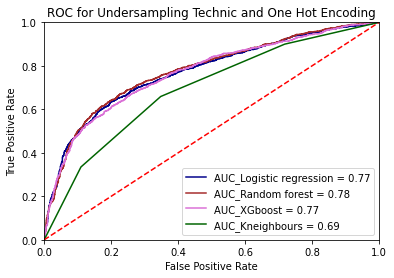

In [528]:
total(clfs, 'ROC for Undersampling Technic and One Hot Encoding')

# SMOTE
## Preprocessing

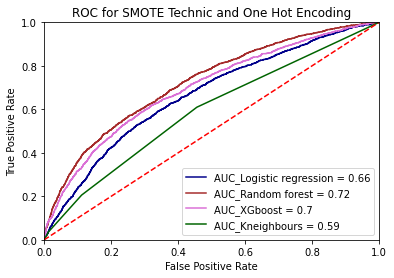

In [529]:
categorical_columns = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2','PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

numerical_columns = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
                     'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
y = df['dpnm'].to_numpy()
X = df[numerical_columns + categorical_columns]

X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

sm = SMOTE(random_state=42) 
X_res, y_res = sm.fit_resample(X,y)


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)


numerical_pipe = Pipeline(steps=[('scaler', StandardScaler())])

preprocessing = ColumnTransformer(
    [
        ("num", numerical_pipe, numerical_columns),
    ]
)
total(clfs, 'ROC for SMOTE Technic and One Hot Encoding')

## Using Labeling instead of OneHot Encoder

Let's use original data

In [530]:
dg = pd.read_csv(filename)

In [531]:
dg.drop(columns='ID', axis=1)
dg.drop_duplicates(inplace=True)

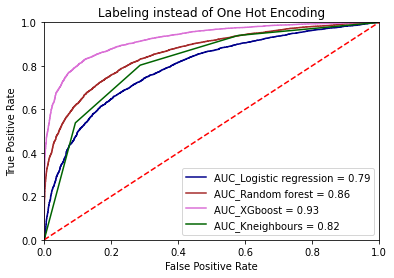

In [532]:
numerical_columns = dg.drop(columns='dpnm').columns

yy = dg['dpnm']
XX = dg.drop(columns='dpnm')

X_cols = XX.columns
y_col = ['status']

Xn = XX.to_numpy()
yn = yy.to_numpy()
random_state=42
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(Xn,yn)

X = pd.DataFrame(X_res, columns=X_cols)
y = pd.DataFrame(y_res, columns=y_col)


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)


numerical_pipe = Pipeline(steps=[('scaler', StandardScaler())])

preprocessing = ColumnTransformer(
    [
        ("num", numerical_pipe, numerical_columns),
    ]
)

total(clfs, 'Labeling instead of One Hot Encoding')

## Choose final model

As seen above; Xgboost results the highest ROC_AUC and we choose it as our final model.

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      5819
           1       0.92      0.82      0.87      5863

    accuracy                           0.88     11682
   macro avg       0.88      0.88      0.88     11682
weighted avg       0.88      0.88      0.88     11682

[[0.92747895 0.07252105]
 [0.17550742 0.82449258]]


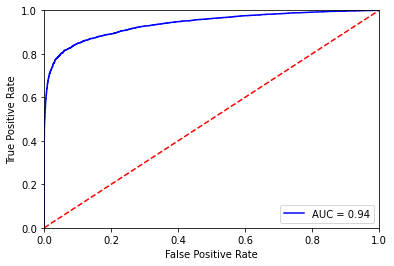

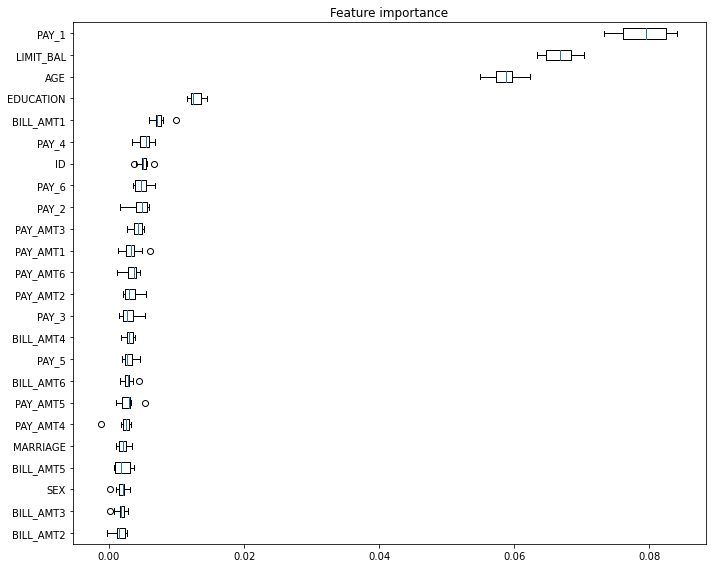

In [536]:
x=dg.drop("dpnm", axis=1)
x = (x-x.mean())/x.std()
y = dg["dpnm"].values
sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_resample(x, y)
x_train, x_test, y_train,y_test = train_test_split(x_res, y_res,test_size= 0.25, random_state = 42)
parm_grid = {'max_depth': [7,11],'learning_rate':[0.2,0.5],'eval_metric':['mlogloss'] }
xgb = XGBClassifier()
grid = GridSearchCV(estimator=xgb, param_grid=parm_grid , cv = 5)
grid.fit(x_train, y_train)
#print(grid.best_score_, grid_result.best_params_)
model=grid.best_estimator_
y_pred2=model.predict(x_test)

print(classification_report(y_test, y_pred2))

print(confusion_matrix(y_test, y_pred2, labels=None, sample_weight=None, normalize='true'))

probs = model.predict_proba(x_test)[:,1]
FalsePositiveRate, TruePositiveRate, threshold, roc_auc = roc_auc_curve(y_test, probs)
label = 'AUC = '    
"{}{}".format(label, round(roc_auc,2))
plt.plot(FalsePositiveRate, TruePositiveRate, 'b', label =  "{}{}".format(label, round(roc_auc,2)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

result = permutation_importance(
    model, x_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10,8))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Feature importance")
fig.tight_layout()
plt.show()
